## Voting, Strategies, Scores, Networks


In [1]:
import matplotlib as plt
import numpy as np
from statistics import stdev

import pandas as pd
pd.set_option('display.max_columns', None)

We have put together the relevant utility functions we have developed so far in one python file called `adsl`, which we can now import.

In [2]:
from adsl import pd_read_dir, pd_read_json

#### Loads proposals, votes, spaces

_Note:_ adjust paths to files as needed for your system.

In [ ]:
# from adsl import gq, gql_all
# query = gq("snapshot_proposals", query_dir="../4_power/gql_queries/")
# res = await gql_all(query,
#                     field="proposals",
#                     first=1000,
#                     rest=True,
#                     data_dir="../4_power/data/",
#                     save="snaphost_proposals.json")

In [3]:
proposals = pd_read_json('../4_power/data/snapshot_proposals.json')
len(proposals)

71670

In [4]:
proposals['space'] =  proposals['space'].apply(lambda x :
                                                None if x is None else x['id'])

In [ ]:
# from adsl import gq, gql_all
# query = gq("snapshot_votes", query_dir="../4_power/gql_queries/")
# res = await gql_all(query,
#                     field="votes",
#                     save_interval=20,
#                     clear_on_save=True,
#                     first=20000,
#                     rest=True,
#                     save="votes.json",
#                     data_dir="data/votes/" ## Must exist.
# ) 

In [7]:
votes = pd_read_dir('../4_power/data/votes/')

In [8]:
len(votes)

5494790

In [9]:
## Cleanup
votes['proposal'] = votes['proposal'].apply(lambda x :
                                            None if x is None else x['id'])
                                            
votes['space'] = votes['space'].apply(lambda x :
                                            None if x is None else x['id'])

votes['vp'] = votes['vp'].astype(float)


In [ ]:
# from adsl import gq, gql_all
# query = gq("snapshot_spaces")
# res = await gql_all(query,
#                     field="spaces",
#                     first=1000,
#                     # rest=True,
#                     save="spaces.json",
#                     data_dir="data/" ## Must exist.
# ) 

In [5]:
spaces = pd_read_json('data/spaces.json')

#### Load strategies

In [ ]:
# from adsl import gq, gql_all
# query = gq("snapshot_strategies")
# res = await gql_all(query,
#                     field="strategies",
#                     save="strategies.json",
#                     limit = 1, # otherwise it goes in infinite loop (first not supported)
#                     data_dir="data/" ## Must exist.
# )

In [4]:
strategies = pd_read_json('data/strategies.json')

In [7]:
strategies.head()

id      author version  \
0  erc20-balance-of  bonustrack   0.1.1   
1            ticket  bonustrack   0.1.0   
2            erc721  bonustrack   0.1.0   
3       eth-balance  bonustrack   0.1.0   
4         whitelist  bonustrack   0.1.0   

                                              schema  \
0  {'$schema': 'http://json-schema.org/draft-07/s...   
1                                               None   
2  {'$schema': 'http://json-schema.org/draft-07/s...   
3                                               None   
4                                               None   

                                            examples  \
0  [{'name': 'Example query', 'strategy': {'name'...   
1  [{'name': 'Example query', 'strategy': {'name'...   
2  [{'name': 'Example query', 'strategy': {'name'...   
3  [{'name': 'Example query', 'strategy': {'name'...   
4  [{'name': 'Example query', 'strategy': {'name'...   

                                               about  spacesCount  
0  # erc20-balance-of\n\nThis is the most common ...         5544  
1                                                            2458  
2  # erc721\n\nThis strategy return the balances ...         1611  
3                                                             551  
4                                                             329

In [10]:
strategies['examples'][2]

[{'name': 'Example query',
  'strategy': {'name': 'erc721',
   'params': {'address': '0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB',
    'symbol': 'PUNK'}},
  'network': '1',
  'addresses': ['0x51688cd36c18891167e8036bde2a8fb10ec80c43',
   '0x3e17fac953de2cd729b0ace7f6d4353387717e9e',
   '0x23f67feb67a3aa1e376d23beaa3f241217e427c9',
   '0x54685c62db8e16b1484768db8e0daf3c644d50bf',
   '0x766bc61d3150232f6f4e1d81633d68f3a94879e3'],
  'snapshot': 12413022}]

In [11]:
strategies['schema'][0]

{'$schema': 'http://json-schema.org/draft-07/schema#',
 '$ref': '#/definitions/Strategy',
 'definitions': {'Strategy': {'title': 'Strategy',
   'type': 'object',
   'properties': {'symbol': {'type': 'string',
     'title': 'Symbol',
     'examples': ['e.g. UNI'],
     'maxLength': 16},
    'address': {'type': 'string',
     'title': 'Contract address',
     'examples': ['e.g. 0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984'],
     'pattern': '^0x[a-fA-F0-9]{40}$',
     'minLength': 42,
     'maxLength': 42},
    'decimals': {'type': 'number',
     'title': 'Decimals',
     'examples': ['e.g. 18']}},
   'required': ['address', 'decimals'],
   'additionalProperties': False}}}

In [5]:
len(strategies)

383

In [12]:
strategies['id']

0                       erc20-balance-of
1                                 ticket
2                                 erc721
3                            eth-balance
4                              whitelist
                     ...                
378                           fight-club
379            deposit-in-sablier-stream
380          aavegotchi-agip-37-wap-ghst
381    aavegotchi-agip-37-gltr-staked-lp
382                 erc20-tokens-per-uni
Name: id, Length: 383, dtype: object

#### Strategies and Voting Power

Let's look into how votes are aggregated by strategies.

Important links:

- https://docs.snapshot.org/proposals/voting-types
- https://docs.snapshot.org/strategies/what-is-a-strategy
- https://snapshot.org/#/?type=strategies
- https://github.com/snapshot-labs/snapshot-strategies/tree/master/src/strategies
- https://snapshot.org/#/?type=networks
- https://github.com/snapshot-labs/snapshot.js/blob/master/src/networks.json


In [91]:
proposals.iloc[0]

id                       QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ
ipfs                     QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ
author                       0x8BBE4Ac64246d600BC2889ef5d83809D138F03DF
created                                                      1595088499
space                                                      balancer.eth
network                                                               1
symbol                                                                 
type                                                      single-choice
strategies            [{'name': 'erc20-balance-of', 'network': '1', ...
plugins                                                              {}
title                 balFactor: incentivizing BAL liquidity on Bala...
body                  Read the formatted version of this proposal at...
discussion                                                             
choices                                               [Approve, 

Each proposal has a specific voting system.

https://docs.snapshot.org/proposals/voting-types

In [92]:
proposals['type'].value_counts()

single-choice    62593
basic             3446
weighted          2327
quadratic         1329
approval          1161
ranked-choice      812
custom               2
Name: type, dtype: int64

<AxesSubplot:>

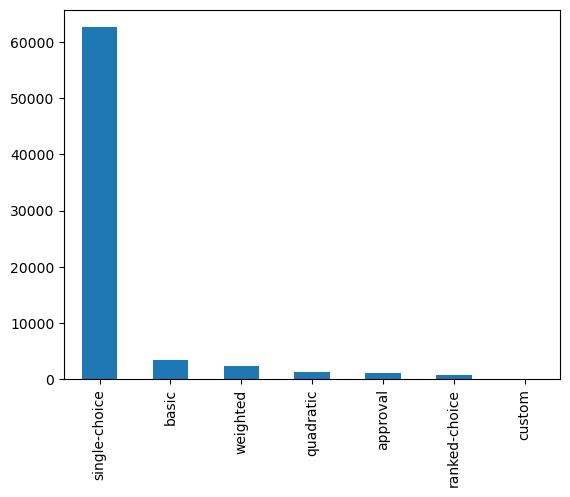

In [33]:
proposals['type'].value_counts().plot(kind="bar")

Let's understand better the relationship between votes, choices, strategies and scores.

In [8]:
proposals['scores_by_strategy_len'] = proposals['scores_by_strategy'].apply(lambda x : len(x))
proposals['choices_len'] = proposals['choices'].apply(lambda x : len(x))
proposals['strategies_len'] = proposals['strategies'].apply(lambda x : len(x))


In [9]:
proposals['choices_len'].value_counts()

2      49445
3      12659
4       3612
5       1914
6        837
       ...  
92         1
127        1
90         1
67         1
198        1
Name: choices_len, Length: 113, dtype: int64

In [108]:
proposals['scores_by_strategy_len'].value_counts()


2      49031
3      12554
4       3562
5       1895
6        826
       ...  
82         1
79         1
65         1
77         1
198        1
Name: scores_by_strategy_len, Length: 113, dtype: int64

In [109]:
proposals['strategies_len'].value_counts()

1    53292
2    10167
3     2800
6     2129
4     1748
7      729
5      633
8      154
0       18
Name: strategies_len, dtype: int64

The distribution of scores_by_strategy is very similar to the distribution of choices, but not identical.

In [110]:
proposals[['strategies_len', 'scores_by_strategy_len', 'choices_len']]
aa = proposals[proposals['scores_by_strategy_len'] - proposals['choices_len'] != 0]
len(aa)

647

In [111]:
aa.state
aa['link'].iloc[2]

'https://snapshot.org/#/sushigov.eth/proposal/QmSg9yVu2L25XhyBa33wNr5vAdvyeYrKn5EBMfQ5rQBwyn'

It seems that the scores_by_strategies_len is different from choices_len when the proposals are some kind of test, and all voters have zero voting power.

Let's find proposals for which there is some controversy.

In [10]:
def is_controversial(scores):
    # print(scores)
    if len(scores) <= 1: return False
    s = np.array(scores)
    s = s / sum(scores)
    # print(s)
    # print('---')
    return stdev(s) < 0.3

proposals['controversial'] = proposals['scores'].apply(is_controversial)

In [29]:
proposals['controversial'].value_counts()

False    8773
True     1227
Name: controversial, dtype: int64

Let's check how many strategies do controversial proposals with two choices have.

In [12]:
df = proposals[(proposals['controversial'] == True) & (proposals['choices_len'] == 2)]
len(df)
df['strategies_len'].value_counts()

1    3195
2     470
3     176
6     119
7      76
4      68
5      45
8       8
Name: strategies_len, dtype: int64

Let's check a particular proposal.

In [13]:
# dff = df[df['strategies_len'] == 1]
dff = df[df['strategies_len'] == 3]
p = dff.iloc[0]
p

id                           QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW
ipfs                         QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW
author                           0x5Dd5FC8761fe933bC58e5aB5Be062dd836DFA801
created                                                          1608084820
space                                                        index-coop.eth
network                                                                   1
symbol                                                                     
type                                                          single-choice
strategies                [{'name': 'erc20-balance-of', 'network': '1', ...
plugins                                                                  {}
title                     IIP-7 CoinShares Gold and Cryptoassets Index L...
body                      ## Simple Summary\n\nThe CoinShares Gold and C...
discussion                                                                 
choices     

In [14]:
p.choices

['FOR', 'AGAINST']

In [15]:
p.id

'QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW'

In [16]:
p.link

'https://snapshot.org/#/index-coop.eth/proposal/QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW'

In [17]:
p.strategies

[{'name': 'erc20-balance-of',
  'network': '1',
  'params': {'symbol': 'INDEX',
   'address': '0x0954906da0Bf32d5479e25f46056d22f08464cab',
   'decimals': 18}},
 {'name': 'uniswap',
  'network': '1',
  'params': {'symbol': 'INDEX',
   'address': '0x0954906da0Bf32d5479e25f46056d22f08464cab',
   'decimals': 18}},
 {'name': 'contract-call',
  'network': '1',
  'params': {'symbol': 'INDEX',
   'address': '0x8f06FBA4684B5E0988F215a47775Bb611Af0F986',
   'decimals': 18,
   'methodABI': {'name': 'earned',
    'type': 'function',
    'inputs': [{'name': 'account',
      'type': 'address',
      'internalType': 'address'}],
    'outputs': [{'name': '', 'type': 'uint256', 'internalType': 'uint256'}],
    'stateMutability': 'view'}}}]

In [18]:
p.scores_by_strategy

[[201587.2773946806, 5561.9983735059, 88.3556615729],
 [136489.5390568919, 0, 0]]

In [19]:
p.scores

[207237.6314297594, 136489.5390568919]

In [35]:
30.393029971843937 + 40.239291019530874

70.63232099137481

In [34]:
19.606970028156052 / 50

0.392139400563121

In [38]:
p.scores_state

'final'

In [49]:
p['scores_by_strategy_len']

2

Let's load all the votes for a proposal with 3 and with 2 strategy and check whether the math is right! \
(files available in ILIAS).

In [61]:
v = pd_read_json("data/votes_prop_three_strategies.json")

In [ ]:
# v = pd_read_json("data/votes_prop_one_strategy.json")

In [62]:
len(v)

93

In [63]:
v['proposal'][0]

{'id': 'QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW'}

In [64]:
v['choice'].value_counts()

1    81
2    12
Name: choice, dtype: int64

In [66]:
groups = v.groupby('choice')

In [67]:
groups.ngroups

2

In [68]:
groups['vp'].sum()

choice
1    207237.631430
2    136489.539057
Name: vp, dtype: float64

In [69]:
p.scores

[207237.6314297594, 136489.5390568919]

#### Statistics about Strategies, Spaces, Proposals

In [39]:
## Here we want to have a dataframe with strategy-proposal rows.
## Takes a few minutes...

proposal_strategies = pd.DataFrame()

def unpack_strategies(row):
    # print(row)
    global proposal_strategies

    s = row['strategies']
    sl = len(s)
    for l in range(sl):
        
        ## It can be None.
        if s[l] is None: continue

        # print(s[l])
        df = {
            'space': row['space'],
            'proposal': row['id'],
            'strategy': s[l]['name'],
            'network': s[l]['network']
        }
        if 'params' in s[l]:
            p = s[l]['params']
            if 'address' in p: df['address'] = s[l]['params']['address']
            if 'symbol' in p: df['symbol'] = s[l]['params']['symbol']
            if 'decimals' in p: df['decimals'] = s[l]['params']['decimals']
        # print(df)
        df = pd.DataFrame.from_records([df])
        # print(df)
        proposal_strategies = pd.concat([proposal_strategies, df], ignore_index=True)

proposals.apply(unpack_strategies, axis=1)
len(proposal_strategies)


111283

Save/load the file.

In [12]:
# proposal_strategies.to_json("data/proposals_strategies.json")
proposal_strategies = pd_read_json("data/proposals_strategies.json")


In [13]:
len(proposal_strategies)

111283

On average, each proposal has 1.5 strategies.

In [42]:
len(proposal_strategies) / len(proposals)

1.552713827263848

In [99]:
proposals.groupby('space').ngroups

8543

In [100]:
votes.groupby('space').ngroups

6301

In [113]:
proposals['strategies_len'].describe()

count    71670.000000
mean         1.552839
std          1.252078
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: strategies_len, dtype: float64

In [115]:
proposal_strategies.head()

space                                        proposal  \
0  balancer.eth  QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ   
1  balancer.eth  QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ   
2  balancer.eth  QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ   
3  balancer.eth  QmXYVj4GBu16GfuTLouxQSvbB8w3G2EAvYq9TAxX38ruKb   
4  balancer.eth  QmXYVj4GBu16GfuTLouxQSvbB8w3G2EAvYq9TAxX38ruKb   

           strategy network                                     address  \
0  erc20-balance-of       1  0xba100000625a3754423978a60c9317c58a424e3D   
1          balancer       1  0xba100000625a3754423978a60c9317c58a424e3D   
2        delegation       1                                         NaN   
3  erc20-balance-of       1  0xba100000625a3754423978a60c9317c58a424e3D   
4          balancer       1  0xba100000625a3754423978a60c9317c58a424e3D   

                      symbol decimals  
0                        BAL     18.0  
1                    BAL BPT      NaN  
2  BAL & BAL BPT (delegated)      NaN  
3                        BAL     18.0  
4                    BAL BPT      NaN

Let's look at proposals by space.

In [14]:
groups = proposal_strategies.groupby('space')

In [16]:
g = groups.groups

In [17]:
IDX = 0
group_name = list(g)[IDX]
groups.get_group(group_name)

space                                           proposal  \
99646  0.robonomics.eth  0xad624d031b50c08ccce85850b0835c8dde05609bcc45...   
99647  0.robonomics.eth  0xd090ed1cb73c5fa0d2484337fa6cf237f403c3c11c2b...   
99649  0.robonomics.eth  0x634be21951fda18ca25a65ae4a17631daa689845c65c...   
99650  0.robonomics.eth  0x70593b51b15a77b3c07f4385c06fc43390761cde636c...   

               strategy network                                     address  \
99646  erc20-balance-of       1  0xa2f4fcb0fde2dd59f7a1873e121bc5623e3164eb   
99647  erc20-balance-of       1  0xa2f4fcb0fde2dd59f7a1873e121bc5623e3164eb   
99649  erc20-balance-of       1  0xa2f4fcb0fde2dd59f7a1873e121bc5623e3164eb   
99650  erc20-balance-of       1  0xa2f4fcb0fde2dd59f7a1873e121bc5623e3164eb   

      symbol decimals  
99646    AIR        0  
99647    AIR        0  
99649    AIR        0  
99650    AIR        0

Always the same strategy across different proposals for this space ("0.robonomics.eth").

In [130]:
groups.get_group(group_name)['strategy'].unique()

array(['erc20-balance-of'], dtype=object)

Let's check how other spaces use strategies.

In [18]:
space_n_strategies = groups.apply(lambda x: len(x['strategy'].unique()))

In [19]:
space_n_strategies.head()

space
0.robonomics.eth    1
00000n.eth          1
000666.eth          1
000729.eth          1
0022446688.eth      1
dtype: int64

Spaces use at most 13 strategies across all proposals.

In [20]:
space_n_strategies.describe()

count    8543.000000
mean        1.312654
std         0.755368
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        13.000000
dtype: float64

Spaces that use more than one strategy.

In [137]:
space_n_strategies[space_n_strategies > 2]

space
0xbrand.eth        3
1.snapspace.eth    7
11alarm.eth        3
12580.eth          3
1inch.eth          4
                  ..
台灣共和國.eth          3
台灣民主自決.eth         3
台灣獨立宣言.eth         3
牛逼666.eth          4
🤓🤓🤓🤓🤓.eth          3
Length: 499, dtype: int64

Let's check the proposals of space `0xbrand.eth` as an example of a space with many strategies.

In [21]:
pp = proposals[proposals['space'] == "0xbrand.eth"]
len(pp)

7

In [148]:
pp

id  \
61919  0xca692ded91f14d6849856c4a3a3b6f4118ef26e90769...   
62215  0x6a873dac41d8f0bf3e1874dc54a3f5ebe393b85d0a34...   
67294  0x7041c1f752b11424c0209e03d874e124da5864f698c1...   
67749  0xd353310bc91120c7cfd8f78faa19eb7e9edbbac19f20...   
67750  0x5a4a5ac25751f5b3ebeea1fc5e5068c87ba9ec1a5fec...   
67763  0x54a0bcaaa687ea92848284c6fa8c235bdb30e58f97e2...   
67765  0xa9b475769f6acf2224ceab5acac63b9e89c4c1dd0bf9...   

                                                    ipfs  \
61919  bafkreihjeavlkybxcbsplio3bakp3wy4up5e5bgbbbcnl...   
62215  bafkreif7giohlsgn5hb7oaksndyxleohgev52cpjr37sj...   
67294  bafkreie4npngthlagvdpymtlgvn3xpseahoowblfl3zg7...   
67749  bafkreibko5dw742py5if5xq2lwfhthcoighb2zbwvpaqh...   
67750  bafkreiea2yk2q5d4btqfppl7p66ueccrf7727svylzxxy...   
67763  bafkreibydssl2uxaqzjfxboacd3v6pvwjhqoiczh6efz7...   
67765  bafkreiat72mhw7twt6xadeyut6ehtz2nuunvg3bzwlmyv...   

                                           author     created        space  \
61919  0xDB9d4e3161Dda1d7444D7076CE418b8e0736038E  1659461702  0xbrand.eth   
62215  0xDB9d4e3161Dda1d7444D7076CE418b8e0736038E  1659632533  0xbrand.eth   
67294  0xDB9d4e3161Dda1d7444D7076CE418b8e0736038E  1663356342  0xbrand.eth   
67749  0xDB9d4e3161Dda1d7444D7076CE418b8e0736038E  1663608162  0xbrand.eth   
67750  0xDB9d4e3161Dda1d7444D7076CE418b8e0736038E  1663608253  0xbrand.eth   
67763  0xDB9d4e3161Dda1d7444D7076CE418b8e0736038E  1663617403  0xbrand.eth   
67765  0x08089613aeC09bC176824b145932f2A3D5Fdba15  1663619677  0xbrand.eth   

      network symbol           type  \
61919       1  PRIME  single-choice   
62215       1  PRIME  single-choice   
67294       1  PRIME  single-choice   
67749       1  PRIME  single-choice   
67750       1  VOTES  single-choice   
67763       1  VOTES  single-choice   
67765       1  VOTES  single-choice   

                                              strategies plugins  \
61919  [{'name': 'erc20-balance-of-cv', 'network': '1...      {}   
62215  [{'name': 'erc20-balance-of-cv', 'network': '1...      {}   
67294  [{'name': 'erc20-balance-of-cv', 'network': '1...      {}   
67749  [{'name': 'erc20-balance-of-cv', 'network': '1...      {}   
67750  [{'name': 'whitelist-weighted', 'network': '1'...      {}   
67763  [{'name': 'echelon-wallet-prime-and-cached-key...      {}   
67765  [{'name': 'echelon-wallet-prime-and-cached-key...      {}   

                         title                body discussion  \
61919                     test        asdfasdfasdf              
62215            afasdfasfasdf  asdddddddddddddddd              
67294                    ddddd         dddasdfasdf              
67749                 asdfasdf            dddddddd              
67750  adfalkdfalsflkanskdfasf                good              
67763                  sdfadsf        adsfasdfasdf              
67765                  sdfadsf        adsfasdfasdf              

                                    choices       start         end  quorum  \
61919                          [tyes, nfgg]  1659461695  1659720895     0.0   
62215                     [fa;sdf, asd;fas]  1659632525  1659891725     0.0   
67294                    [ddd, ddddddddddd]  1663356328  1663615528     0.0   
67749  [dddd, asdfasdfasdfasdfasdfasdfasdf]  1663608159  1663867359     0.0   
67750                          [asdf, fdsa]  1663608246  1663867446     0.0   
67763                            [dd, dddd]  1663617400  1663876600     0.0   
67765                            [dd, dddd]  1663617400  1663876600     0.0   

       snapshot   state                                               link  \
61919  15264452  closed  https://snapshot.org/#/0xbrand.eth/proposal/0x...   
62215  15277101  closed  https://snapshot.org/#/0xbrand.eth/proposal/0x...   
67294  15548235  closed  https://snapshot.org/#/0xbrand.eth/proposal/0x...   
67749  15569008  closed  https://snapshot.org/#/0xbrand.eth/proposal/0x...   
67750  15569015  closed  https://snapshot.org/#/0xbrand.eth/propo

In [144]:
pp.strategies_len

61919    1
62215    2
67294    2
67749    2
67750    1
67763    1
67765    1
Name: strategies_len, dtype: int64

Let's see how strategies are combined into proposals.

In [153]:
for s in pp.strategies:
    l = len(s)
    print(l)
    print(s[0]['name'])
    if (l > 1): print(s[1]['name'])

1
erc20-balance-of-cv
2
erc20-balance-of-cv
whitelist-weighted
2
erc20-balance-of-cv
whitelist-weighted
2
erc20-balance-of-cv
whitelist-weighted
1
whitelist-weighted
1
echelon-wallet-prime-and-cached-key
1
echelon-wallet-prime-and-cached-key


In [22]:
dao_0xbrand = groups.get_group("0xbrand.eth")
dao_0xbrand

space                                           proposal  \
94699   0xbrand.eth  0xca692ded91f14d6849856c4a3a3b6f4118ef26e90769...   
95121   0xbrand.eth  0x6a873dac41d8f0bf3e1874dc54a3f5ebe393b85d0a34...   
95122   0xbrand.eth  0x6a873dac41d8f0bf3e1874dc54a3f5ebe393b85d0a34...   
103870  0xbrand.eth  0x7041c1f752b11424c0209e03d874e124da5864f698c1...   
103871  0xbrand.eth  0x7041c1f752b11424c0209e03d874e124da5864f698c1...   
104518  0xbrand.eth  0xd353310bc91120c7cfd8f78faa19eb7e9edbbac19f20...   
104519  0xbrand.eth  0xd353310bc91120c7cfd8f78faa19eb7e9edbbac19f20...   
104520  0xbrand.eth  0x5a4a5ac25751f5b3ebeea1fc5e5068c87ba9ec1a5fec...   
104538  0xbrand.eth  0x54a0bcaaa687ea92848284c6fa8c235bdb30e58f97e2...   
104540  0xbrand.eth  0xa9b475769f6acf2224ceab5acac63b9e89c4c1dd0bf9...   

                                   strategy network  \
94699                   erc20-balance-of-cv       1   
95121                   erc20-balance-of-cv       1   
95122                    whitelist-weighted       1   
103870                  erc20-balance-of-cv       1   
103871                   whitelist-weighted       1   
104518                  erc20-balance-of-cv       1   
104519                   whitelist-weighted       1   
104520                   whitelist-weighted       1   
104538  echelon-wallet-prime-and-cached-key       1   
104540  echelon-wallet-prime-and-cached-key       1   

                                           address symbol decimals  
94699   0xb23d80f5FefcDDaa212212F028021B41DEd428CF  PRIME       18  
95121   0xb23d80f5FefcDDaa212212F028021B41DEd428CF  PRIME       18  
95122                                         None  PRIME     None  
103870  0xb23d80f5FefcDDaa212212F028021B41DEd428CF  PRIME       18  
103871                                        None  PRIME     None  
104518  0xb23d80f5FefcDDaa212212F028021B41DEd428CF  PRIME       18  
104519                                        None  PRIME     None  
104520                                        None  VOTES     None  
104538  0xb23d80f5FefcDDaa212212F028021B41DEd428CF  VOTES       18  
104540  0xb23d80f5FefcDDaa212212F028021B41DEd428CF  VOTES       18

In [169]:
dao_0xbrand[['proposal', 'strategy']].pivot(index="proposal", columns="strategy", values="strategy")

strategy                                            echelon-wallet-prime-and-cached-key  \
proposal                                                                                  
0x54a0bcaaa687ea92848284c6fa8c235bdb30e58f97e2d...  echelon-wallet-prime-and-cached-key   
0x5a4a5ac25751f5b3ebeea1fc5e5068c87ba9ec1a5fec8...                                  NaN   
0x6a873dac41d8f0bf3e1874dc54a3f5ebe393b85d0a349...                                  NaN   
0x7041c1f752b11424c0209e03d874e124da5864f698c1b...                                  NaN   
0xa9b475769f6acf2224ceab5acac63b9e89c4c1dd0bf94...  echelon-wallet-prime-and-cached-key   
0xca692ded91f14d6849856c4a3a3b6f4118ef26e90769a...                                  NaN   
0xd353310bc91120c7cfd8f78faa19eb7e9edbbac19f207...                                  NaN   

strategy                                            erc20-balance-of-cv  \
proposal                                                                  
0x54a0bcaaa687ea92848284c6fa8c235bdb30e58f97e2d...                  NaN   
0x5a4a5ac25751f5b3ebeea1fc5e5068c87ba9ec1a5fec8...                  NaN   
0x6a873dac41d8f0bf3e1874dc54a3f5ebe393b85d0a349...  erc20-balance-of-cv   
0x7041c1f752b11424c0209e03d874e124da5864f698c1b...  erc20-balance-of-cv   
0xa9b475769f6acf2224ceab5acac63b9e89c4c1dd0bf94...                  NaN   
0xca692ded91f14d6849856c4a3a3b6f4118ef26e90769a...  erc20-balance-of-cv   
0xd353310bc91120c7cfd8f78faa19eb7e9edbbac19f207...  erc20-balance-of-cv   

strategy                                            whitelist-weighted  
proposal                                                                
0x54a0bcaaa687ea92848284c6fa8c235bdb30e58f97e2d...                 NaN  
0x5a4a5ac25751f5b3ebeea1fc5e5068c87ba9ec1a5fec8...  whitelist-weighted  
0x6a873dac41d8f0bf3e1874dc54a3f5ebe393b85d0a349...  whitelist-weighted  
0x7041c1f752b11424c0209e03d874e124da5864f698c1b...  whitelist-weighted  
0xa9b475769f6acf2224ceab5acac63b9e89c4c1dd0bf94...                 NaN  
0xca692ded91f14d6849856c4a3a3b6f4118ef26e90769a...                 NaN  
0xd353310bc91120c7cfd8f78faa19eb7e9edbbac19f207...  whitelist-weighted

Let's create a dataframe of rows proposal-set-of-strategies for all daos.

In [23]:
def strategy_group(x):
    s = str(x['strategy'])
    # print('---------------')
    if len(s) == 1: 
        s = s[0]
    else:
        ## Join strategy names together for multiple strategies.
        s = sorted(x['strategy'])
        s = '_'.join(s)
    # print(s)
    return(s)


In [24]:
proposal_strategies_by_prop = proposal_strategies.groupby(['space', 'proposal']).apply(strategy_group)

In [25]:
proposal_strategies_by_prop

space             proposal                                                          
0.robonomics.eth  0x634be21951fda18ca25a65ae4a17631daa689845c65c541cae065c22a3024c35    erc20-balance-of
                  0x70593b51b15a77b3c07f4385c06fc43390761cde636ca2dc730e61a9095f4117    erc20-balance-of
                  0xad624d031b50c08ccce85850b0835c8dde05609bcc45263e519ffa0289479b64    erc20-balance-of
                  0xd090ed1cb73c5fa0d2484337fa6cf237f403c3c11c2bf3398604c266a3cc8270    erc20-balance-of
00000n.eth        0x34bac528ff1305869f486a79e9956d96fd6db65357f9caa308836053cb401b39              erc721
                                                                                              ...       
🤙🤙🤙🤙🤙🤙.eth        QmbYHn8qiTwvZgegEGEBayTbP8kFgZk83pMmaSCiuqhYoU                                  ticket
                  QmdrZ514Q7G3eee3c2dnnFzNLrz9HSbiBcaYPbSZbNwNTq                                  ticket
                  QmdyK2g3TDzdwELyayDnMfEByxpe8BNfYc7AkEKXLZuU6T           

Let's count the number of unique sets of strategies used across proposals.

In [26]:
space_len_strategies = proposal_strategies_by_prop.groupby('space').apply(lambda x : len(x.unique()))

In [27]:
space_len_strategies.describe()

count    8543.000000
mean        1.255297
std         0.764786
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        17.000000
dtype: float64

<AxesSubplot:ylabel='Frequency'>

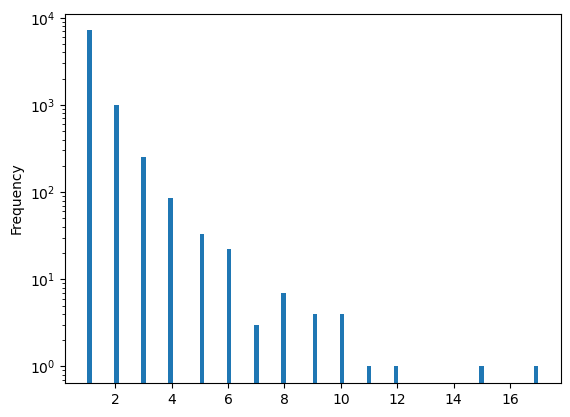

In [28]:
space_len_strategies.plot.hist(bins=100, log=True)

In [233]:
space_len_strategies[space_len_strategies > 10]

space
4.spaceshot.eth    12
bitdecay.eth       11
dakshow.eth        15
lyratest.eth       17
dtype: int64

#### Networks

<AxesSubplot:>

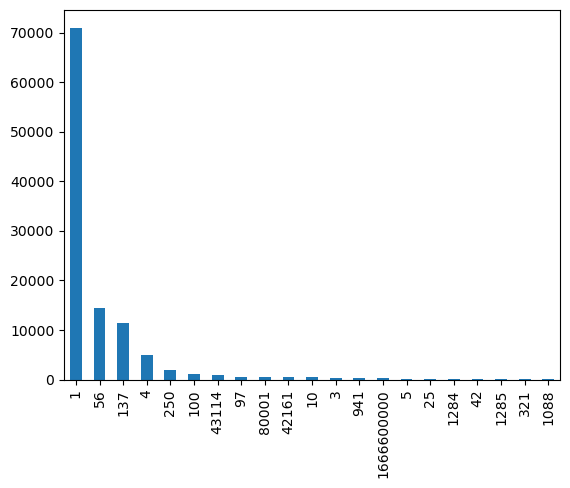

In [29]:
networks = proposal_strategies['network'].value_counts()
networks[networks > 100].plot(kind="bar")

#### Get all contracts
Let's gather all the contracts used by all strategies across all daos.

In [242]:
for a in proposal_strategies['address']:
    print(a)

0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xba100000625a3754423978a60c9317c58a424e3D
0xba100000625a3754423978a60c9317c58a424e3D
nan
0xAba8cAc6866B83Ae4eec97DD07ED254282f6aD8A
0xAba8cAc6866B83Ae4eec97DD07ED254282f6aD8A
0xAba8cAc6866B

In [243]:
for a in proposal_strategies['address']:
    print(type(a))

<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'str'>
<class 'str'>
<class 'st

In [30]:
proposal_strategies['address_type'] = proposal_strategies.apply(lambda x : str(type(x['address'])), axis=1)

In [31]:
proposal_strategies['address_type']

0              <class 'str'>
1              <class 'str'>
2         <class 'NoneType'>
3              <class 'str'>
4              <class 'str'>
                 ...        
111278    <class 'NoneType'>
111279    <class 'NoneType'>
111280         <class 'str'>
111281         <class 'str'>
111282    <class 'NoneType'>
Name: address_type, Length: 111283, dtype: object

There are a few strategies that use a list of addresses.

In [257]:
aa = proposal_strategies[ proposal_strategies['address_type'] == "<class 'list'>" ]
len(aa)

3

In [262]:
aa

space                                        proposal  \
18378  chiliagon.eth  QmZfCfneRNwtRRcyeLBH8nCDKA83AsK7NJVyaGWURgbCXj   
19145  chiliagon.eth  QmNRk1RFAn3GDQJP4MfRWnchKD16stnNWiA7XHuuJAWi1k   
20707  chiliagon.eth  QmRkiBr7MTfCfUC4yAphi5wm1dKB952EPQ2xRELkAWFmAM   

        strategy network                                            address  \
18378  whitelist     137  [0x51FcFc7D4A032478B8919e30cE52B39FbE823Fe8, 0...   
19145  whitelist     137  [0x51FcFc7D4A032478B8919e30cE52B39FbE823Fe8, 0...   
20707  whitelist     137  [0x51FcFc7D4A032478B8919e30cE52B39FbE823Fe8, 0...   

      symbol decimals    address_type  
18378    DAI      NaN  <class 'list'>  
19145    DAI      NaN  <class 'list'>  
20707    DAI      NaN  <class 'list'>

In [261]:
for a in aa['address']: print(a)

['0x51FcFc7D4A032478B8919e30cE52B39FbE823Fe8', '0x1eB0487d99dC24B326faC3D63ADb913F88c8A542', '0x9E61BBFc291563817408AC19c3EA3b66936ae1AD', '0x9EDb85517e6b54Fe9968F72D408B45661FA2252e']
['0x51FcFc7D4A032478B8919e30cE52B39FbE823Fe8', '0x1eB0487d99dC24B326faC3D63ADb913F88c8A542', '0x9E61BBFc291563817408AC19c3EA3b66936ae1AD', '0x9EDb85517e6b54Fe9968F72D408B45661FA2252e']
['0x51FcFc7D4A032478B8919e30cE52B39FbE823Fe8', '0x1eB0487d99dC24B326faC3D63ADb913F88c8A542', '0x9E61BBFc291563817408AC19c3EA3b66936ae1AD', '0x9EDb85517e6b54Fe9968F72D408B45661FA2252e']


In [32]:
address_type_groups = proposal_strategies.groupby('address_type')

In [33]:
address_type_groups.groups.keys()

dict_keys(["<class 'NoneType'>", "<class 'list'>", "<class 'str'>"])

In [272]:
for gg in address_type_groups.groups: print(gg, len(address_type_groups.get_group(gg)))

<class 'float'> 28235
<class 'list'> 3
<class 'str'> 83045


What are the floats?

In [274]:
address_type_groups.get_group("<class 'float'>")

space                                           proposal  \
2       balancer.eth     QmSXpyHBrkjzjmGpdYxKvYoRAMvdJNp7rrnyvJqTdtpayZ   
5       balancer.eth     QmXYVj4GBu16GfuTLouxQSvbB8w3G2EAvYq9TAxX38ruKb   
8       balancer.eth     QmboDWvsXYXPZb44arPVoMa3LHuv74YsGZ3cSoG6uj4oZe   
11      balancer.eth     QmeWmvdFCTq5tnFHqgFmAVJDCccTYjg1zWb9cfUByg7zbz   
14      balancer.eth     QmUadcUgd3jAhJbofgrnKNMfeuGFvMmybhCkttW4gGfYYJ   
...              ...                                                ...   
111272    199820.eth  0xe0f7b517225eabcdea5ae5c92d26b63a9ab086188124...   
111277  kogecoin.eth  0x6fb22f1cbbcce5b10516fc7e6d84ed4a11e32100ace2...   
111278  kogecoin.eth  0x6fb22f1cbbcce5b10516fc7e6d84ed4a11e32100ace2...   
111279  kogecoin.eth  0x6fb22f1cbbcce5b10516fc7e6d84ed4a11e32100ace2...   
111282    haurog.eth  0xdd5e0c0730e4e3a74952d0eb50b84378b44f914bf5f4...   

                             strategy network address  \
2                          delegation       1     NaN   
5                          delegation       1     NaN   
8                          delegation       1     NaN   
11                         delegation       1     NaN   
14                         delegation       1     NaN   
...                               ...     ...     ...   
111272                    eth-balance   42161     NaN   
111277        masterchef-pool-balance     137     NaN   
111278        masterchef-pool-balance     137     NaN   
111279  masterchef-pool-balance-price     137     NaN   
111282                      whitelist       1     NaN   

                           symbol decimals     address_type  
2       BAL & BAL BPT (delegated)      NaN  <class 'float'>  
5       BAL & BAL BPT (delegated)      NaN  <class 'float'>  
8       BAL & BAL BPT (delegated)      NaN  <class 'float'>  
11      BAL & BAL BPT (delegated)      NaN  <class 'float'>  
14      BAL & BAL BPT (delegated)      NaN  <class 'float'>  
...                           ...      ...              ...  
111272                        ETH      NaN  <class 'float'>  
111277               KOGECOIN (s)      NaN  <class 'float'>  
111278            KOGECOIN (vert)      NaN  <class 'float'>  
111279            KOGECOIN LP (s)       18  <class 'float'>  
111282                       VOTE      NaN  <class 'float'>  

[28235 rows x 8 columns]

Are they all delegations?

In [276]:
address_type_groups.get_group("<class 'float'>").value_counts('strategy')

strategy
ticket                       6637
delegation                   5973
multichain                   4668
eth-balance                  1898
pagination                   1381
                             ... 
hopr-staking-s2                 1
synthetix-non-quadratic         1
hopr-uni-lp-farm                1
sybil-protection                1
sd-boost-delegation-twavp       1
Length: 181, dtype: int64